In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device} is available")

cuda:0 is available


In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels), # Batch Normalization
            nn.ReLU(),
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels))
        if self.stride != 1 or self.in_channels != self.out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.out_channels))

    def forward(self, x):
        out = self.conv_block(x)
        if self.stride != 1 or self.in_channels != self.out_channels:
            x = self.downsample(x)
        out = F.relu(x + out)
        return out

In [44]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.base = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        self.gap = nn.AvgPool2d(4) # filter size is 4
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            block = ResidualBlock(self.in_channels, out_channels, stride)
            layers.append(block)
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [45]:
def modeltype(model):
    if model == 'resnet18':
        return ResNet([2, 2, 2, 2])
    elif model == 'resnet34':
        return ResNet([3, 4, 6, 3])

In [46]:
criterion = nn.CrossEntropyLoss()

resnet = modeltype('resnet18').to(device)
print(resnet)

PATH = './models/cifar_resnet.pth'

optimizer = optim.Adam(resnet.parameters(), lr=1e-3)

ResNet(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kerne

In [47]:
loss_ = []
n = len(trainloader)
for epoch in range(50):
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_.append(running_loss / n)
    print(f"{epoch + 1} loss: {running_loss / len(trainloader):.3f}")

1 loss: 1.351
2 loss: 0.829
3 loss: 0.615
4 loss: 0.477
5 loss: 0.365
6 loss: 0.268
7 loss: 0.187
8 loss: 0.132
9 loss: 0.106
10 loss: 0.081
11 loss: 0.069
12 loss: 0.061
13 loss: 0.057
14 loss: 0.048
15 loss: 0.045
16 loss: 0.040
17 loss: 0.039
18 loss: 0.034
19 loss: 0.035
20 loss: 0.027
21 loss: 0.031
22 loss: 0.026
23 loss: 0.025
24 loss: 0.027
25 loss: 0.023
26 loss: 0.021
27 loss: 0.023
28 loss: 0.019
29 loss: 0.021
30 loss: 0.017
31 loss: 0.021
32 loss: 0.017
33 loss: 0.015
34 loss: 0.016
35 loss: 0.016
36 loss: 0.016
37 loss: 0.015
38 loss: 0.013
39 loss: 0.015
40 loss: 0.015
41 loss: 0.013
42 loss: 0.012
43 loss: 0.013
44 loss: 0.011
45 loss: 0.014
46 loss: 0.011
47 loss: 0.011
48 loss: 0.011
49 loss: 0.010
50 loss: 0.012


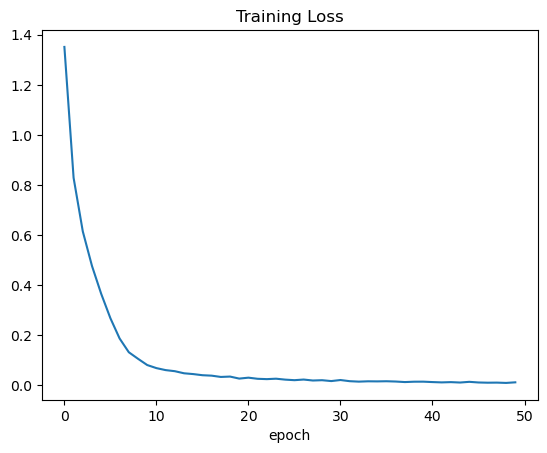

In [51]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [52]:
correct = 0
total = 0
with torch.no_grad():
    resnet.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {(100 * correct / total): .2f}%')

Test Accuracy:  85.23%


In [50]:
torch.save(resnet.state_dict(), PATH)